In [259]:
!pip install kneed
from kneed import KneeLocator #for finding the convergence point on plots

random.seed(0)

import pandas as pd
from IPython.display import clear_output
import random
import gym
import numpy as np
import time
from uofgsocsai import LochLomondEnv # load the class defining the custom Open AI Gym problem
import os, sys
from helpers import *
import agent_eval
import matplotlib.pyplot as plt

import os, sys
from copy import deepcopy 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import lines
import networkx as nx
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
AIMA_TOOLBOX_ROOT="aima-python-uofg_v20192020b"
sys.path.append(AIMA_TOOLBOX_ROOT)

from search import *
from notebookutils import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens
# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

'''
Concepts learnt and some ideas for code taken from deeplizard.com
Simple agent uses AIMA toolbox codes and  from ARTIFICIAL INTELLIGENCE (H/M) laboratory notebooks.


'''

# RL Agent:
   ## 1) Policy 
   ## 2) qLearningAgent
   
   

### Accuracy of RL agent is measured over the testing phase where learning rate is 0

In [260]:
def policy(q_table,env):
    '''
    It takes the Q-table and the env shape ie loactaions and gives the policy based on the the Q-table
    
    '''
    
    
    env.reset()
    if q_table.shape==(64,4):              #8X8 q_table
        policy_matrix=np.empty((64,1),dtype='U10') #initiallizing the policy matrix
        temp_table=np.empty((64,1),dtype='U10')    #temporary table 64X1
        count=0
        m_table=env.desc.ravel().reshape((64,1))  #m_table contains the env.desc in 64X1
        for x in m_table:                        #for each b'H' in m_table, assign str='H' in the temporary table
            if x==b'H':
                temp_table[count]='Hole'
            elif x==b'G':                      #Goal should be also explicitely shown in the temporary table
                temp_table[count]='Goal'
                
                
            count+=1   #count incremented by 1
            
        count=0 #count reset to 0 so that it can be reused in the below for loops
                
        
        
        
        
        #Now, taking argmax from each state of q_table and storing the 0,1,2,3 in temp_table:
        for state in q_table:
            if temp_table[count]=='Hole' or temp_table[count]=='Goal':  #not changing the Hole and Goal in the temp_table
                count+=1
                
                
                continue  
            
            
            else:
                '''
                Some NON-HOLE states weren't learnt at all, all the 4 columns in those states were 0s. 
                These states will contain a string: null
                '''
                
                
                if np.allclose(state,np.zeros((1,4))):    #unlearnt states set to 'null'
                    temp_table[count]='null'
                    count+=1
                else:
                
                    temp_table[count]=np.argmax(state)  #states that were learnt
                    count+=1
        
        
        for i in range(64):
            if temp_table[i]=='Hole' or temp_table[i]=='Goal' or temp_table[i]=='null':
                policy_matrix[i]=temp_table[i]  #explicitely storing hole,goal and nulls
                
                
                continue
            
            
            if temp_table[i]=='0':     #if left
                policy_matrix[i]='<'
            elif temp_table[i]=='1':   #if down
                policy_matrix[i]='down'
            elif temp_table[i]=='2':   #if right
                policy_matrix[i]='>'
            elif temp_table[i]=='3':   #if up
                policy_matrix[i]='^'
        #print(p_table)               #debug
        return policy_matrix.reshape((8,8)), temp_table.reshape((8,8))
                
                
    

In [261]:
def qLearningAgent(problem_id,map_name_base,max_episodes,max_iter_per_episode,exploration_rate,\
                   learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                   reward,reward_hole, is_stochastic, discount_rate):
    
    '''
    Returns: q_table, accuracy, reward_per_episode, state_df,env. reward_per_episode is the averaged rewards gained
    per 1000 episode, state_df gives the utility of the states for every episode. Accuracy is goal/(goal+hole) under testing phase
    
    
    '''
    
    
    
    
    env = LochLomondEnv(problem_id=problem_id, is_stochastic=is_stochastic,\
                        map_name_base=map_name_base, reward_hole=reward_hole,reward=reward)
    
    testing_phase=int(max_episodes-0.2*max_episodes)  # if max_episodes is 100,000 then testing phase will begin at episode 80,000 
    
    start_time=time.time()
    env.reset()
    q_table=np.zeros((env.observation_space.n, env.action_space.n))
    #q_convergence=pd.DataFrame() #a df object to store the Q values of each state (64Xmax_episodes) or (16Xmax_episodes)

    state_df=pd.DataFrame(index=list(range(env.observation_space.n)))

    goal_count=0 #to check how many goals acieved for all episodes combined
    hole_count=0 #to check how many holes the agent fell into for all episodes combined

    episode_count=1
    reward_per_episode=[]
    reward_sum=0
    for episodes in range(max_episodes):
        state=env.reset()  #it is 0 and env.reset always returns the initial state in any map be it cartpole or frozenlake
        done=False


        for step in range(max_iter_per_episode):

            #first agent will either explore and then leans towards exploit gradually
            if random.uniform(0,1) > exploration_rate:
                #it will exploit
                action=np.argmax(q_table[state,:]) #action will be the max value in the row no (state)


            else:

                #it will explore randomly

                action=env.action_space.sample()

            new_state,reward,done,info=env.step(action) #once agent has decided an action, it will take the step
            #however, due to randomness, the next_state may not be intended.
            #result will be the next state, reward, done or not and some info(some env return info)

            if episodes<testing_phase:

                #learning phase
                q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                                learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
                state=new_state
                reward_sum+=reward #summing reward on each step
                if done == True:
                    break




            else:
                #testing phase
                learning_rate=0 #it will stop learning now and move on learned q_table
                q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                                learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))


                state=new_state #after taking the action, environment returned the observation of the next state, and so agent will
                                #go into this state.
                reward_sum+=reward #summing reward on each step

                if done == True and reward==1:
                    goal_count+=1
                    break
                elif done==True and reward==reward_hole:
                    hole_count+=1
                    break

        exploration_rate = min_exploration_rate +(max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episodes) #hands-on intelligent agents with OpenAI Gym
        # exploration_rate formula taken from deeplizard.com
        
        state_df[episodes]=np.max(q_table,axis=1)


        if episode_count==1000:
            reward_per_episode.append(reward_sum/episode_count)  #every 1000 episode, append the average rewards 
            reward_sum=0
            episode_count=0

        episode_count+=1
        '''
        q_2.append(np.mean(q_table[2]))


        '''

        #reward_per_episode.append(reward_sum) #appending the total reward gained at each episode

    accuracy=(goal_count/(goal_count+hole_count)) *100

    print(f"Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: {accuracy}\n")

        #-------------------------------------------------------------------Time------------------
    end_time=time.time()-start_time
    if q_table.shape==(64,4):
        print("The time it took to train the agent in a 8X8 maze:\n")
        print(time.strftime("%H:%M:%S", time.gmtime(end_time)))
    else:
        print("The time it took to train the agent in a 4X4 maze:\n")
        print(time.strftime("%H:%M:%S", time.gmtime(end_time)))



    return q_table, accuracy, reward_per_episode, state_df,env
        
        
        


## 8X8

### problem ID: 0

In [262]:
accuracy_rl=[] #to be used in bar plots
reward_df=pd.DataFrame()

In [263]:
problem_id=0
map_name_base='8x8-base'
max_episodes=50000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
        
q_table_0, accuracy_0, reward_per_episode_0, state_df_0,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)
print("The accuracy at testing phase is : {}".format(accuracy_0))
print("problem_id: 0, Agent Trained. Below is the policy: \n")
print(policy(q_table_0,env)[0])

Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 0.22710068130204392

The time it took to train the agent in a 8X8 maze:

00:05:21
The accuracy at testing phase is : 0.22710068130204392
problem_id: 0, Agent Trained. Below is the policy: 

[['<' '<' '<' '<' '<' 'Hole' '>' '^']
 ['<' '^' '^' '^' '^' 'down' '<' 'Hole']
 ['<' '<' '<' 'Hole' '>' '^' '>' 'down']
 ['<' '<' '^' 'down' '<' 'Hole' '>' 'down']
 ['<' '^' '^' 'Hole' '>' 'down' '^' '^']
 ['<' 'Hole' 'Hole' '>' '^' '<' 'Hole' '>']
 ['<' 'Hole' 'down' '<' 'Hole' '>' 'Hole' 'down']
 ['<' 'down' '<' 'Hole' 'Goal' 'down' 'down' 'Hole']]


In [264]:
accuracy_rl.append(accuracy_0)
print(len(reward_per_episode_0))
reward_df[0]=reward_per_episode_0

50


### problem ID: 1

In [265]:
problem_id=1
map_name_base='8x8-base'
max_episodes=50000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
        
q_table_1, accuracy_1, reward_per_episode_1, state_df_1,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)
print("The accuracy at testing phase is : {}".format(accuracy_1))
print("problem_id: 1, Agent Trained. Below is the policy: \n")
print(policy(q_table_1,env)[0])

Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 17.468531468531467

The time it took to train the agent in a 8X8 maze:

00:03:57
The accuracy at testing phase is : 17.468531468531467
problem_id: 1, Agent Trained. Below is the policy: 

[['Hole' '>' '>' '>' '<' 'Hole' '>' '^']
 ['down' '^' '^' '^' '^' 'down' '<' 'Hole']
 ['^' '^' '<' 'Hole' '>' '^' '>' 'down']
 ['<' '^' '<' 'down' '<' 'Hole' '>' 'down']
 ['<' '^' '^' 'Hole' '>' 'down' '^' '^']
 ['<' 'Hole' 'Hole' '>' '^' '<' 'Hole' '>']
 ['<' 'Hole' 'down' '^' 'Hole' '>' 'Hole' '>']
 ['<' 'down' '<' 'Hole' 'null' 'Goal' 'null' 'Hole']]


In [266]:
accuracy_rl.append(accuracy_1)
reward_df[1]=reward_per_episode_1

### problem id: 2 

In [267]:
problem_id=2
map_name_base='8x8-base'
max_episodes=50000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99





q_table_2, accuracy_2, reward_per_episode_2, state_df_2,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)

print("The accuracy is : {}".format(accuracy_2))
print("problem_id: 2, Agent Trained. Below is the policy: \n")
print(policy(q_table_2,env)[0])

Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 83.35585819731781

The time it took to train the agent in a 8X8 maze:

00:02:45
The accuracy is : 83.35585819731781
problem_id: 2, Agent Trained. Below is the policy: 

[['Hole' '>' '<' '<' '<' 'Hole' '>' '^']
 ['down' '<' '<' '^' '<' 'down' '<' 'Hole']
 ['<' '<' '<' 'Hole' '>' '^' '^' 'down']
 ['<' '<' '<' 'down' '<' 'Hole' '>' '^']
 ['<' '^' '^' 'Hole' '>' 'down' '^' '>']
 ['<' 'Hole' 'Hole' '^' 'down' '<' 'Hole' '>']
 ['<' 'Hole' 'down' '^' 'Hole' '>' 'Hole' '<']
 ['Goal' '<' '<' 'Hole' '>' 'down' '^' 'Hole']]


In [268]:
accuracy_rl.append(accuracy_2)
reward_df[2]=reward_per_episode_2

### problem ID: 3

In [269]:
problem_id=3
map_name_base='8x8-base'
max_episodes=50000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.0001 #lesser decay rate ensures more exploration
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
q_table_3, accuracy_3, reward_per_episode_3, state_df_3,env=\
                                       qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)
print("The accuracy is : {}".format(accuracy_3))
print("problem_id: 3, Agent Trained. Below is the policy: \n")
print(policy(q_table_3,env)[0])

Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 63.12871686321944

The time it took to train the agent in a 8X8 maze:

00:02:30
The accuracy is : 63.12871686321944
problem_id: 3, Agent Trained. Below is the policy: 

[['Hole' '>' '<' '<' '<' 'Hole' '>' '^']
 ['down' '<' '<' '^' '^' 'down' '<' 'Hole']
 ['down' '<' '<' 'Hole' '>' '^' '<' 'down']
 ['down' '<' '<' 'down' '<' 'Hole' '>' '^']
 ['<' '^' '^' 'Hole' '>' 'down' '^' '^']
 ['<' 'Hole' 'Hole' 'down' '^' '<' 'Hole' '>']
 ['<' 'Hole' '>' 'down' 'Hole' '>' 'Hole' '<']
 ['down' 'down' 'Goal' 'Hole' '^' '^' '<' 'Hole']]


In [270]:
accuracy_rl.append(accuracy_3)
reward_df[3]=reward_per_episode_3

### problem ID: 4

In [271]:
problem_id=4
map_name_base='8x8-base'
max_episodes=50000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001 #lesser decay rate ensures more exploration
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
q_table_4, accuracy_4, reward_per_episode_4, state_df_4,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)
print("The accuracy is : {}".format(accuracy_4))
print("problem_id: 4, Agent Trained. Below is the policy: \n")
print(policy(q_table_4,env)[0])

Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 61.734528566799874

The time it took to train the agent in a 8X8 maze:

00:03:06
The accuracy is : 61.734528566799874
problem_id: 4, Agent Trained. Below is the policy: 

[['Hole' '>' '<' '<' '<' 'Hole' '>' '^']
 ['down' '<' '<' '^' '^' 'down' '<' 'Hole']
 ['>' '<' '<' 'Hole' '>' '^' '^' 'down']
 ['<' '^' '^' 'down' '<' 'Hole' '>' '^']
 ['<' '^' '<' 'Hole' '>' 'down' '^' '^']
 ['<' 'Hole' 'Hole' '>' '^' '<' 'Hole' '>']
 ['<' 'Hole' '<' '<' 'Hole' '<' 'Hole' 'down']
 ['down' 'down' 'Goal' 'Hole' 'down' '>' 'down' 'Hole']]


In [272]:
accuracy_rl.append(accuracy_4)
reward_df[4]=reward_per_episode_4

### problem ID: 5

In [273]:
problem_id=5
map_name_base='8x8-base'
max_episodes=50000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001 #lesser decay rate ensures more exploration
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
q_table_5, accuracy_5, reward_per_episode_5, state_df_5,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                    reward,reward_hole, is_stochastic, discount_rate)
print("The accuracy is : {}".format(accuracy_5))                                                        
print("problem_id: 5, Agent Trained. Below is the policy: \n")
print(policy(q_table_5,env)[0])

Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 78.18065479364402

The time it took to train the agent in a 8X8 maze:

00:03:22
The accuracy is : 78.18065479364402
problem_id: 5, Agent Trained. Below is the policy: 

[['Hole' '>' '<' '<' '<' '<' '<' '^']
 ['down' '<' '<' '^' '^' '^' '<' 'Hole']
 ['<' '<' '<' 'Hole' '>' '^' '^' 'down']
 ['<' '<' '<' '^' '<' 'Hole' '>' '^']
 ['<' '^' '<' 'Hole' '>' 'down' '^' '^']
 ['<' 'Hole' 'Hole' '>' '^' '<' 'Hole' '>']
 ['<' 'Hole' 'down' '>' 'Hole' '>' 'Hole' '^']
 ['down' 'down' 'down' 'Goal' '<' 'down' 'down' 'Hole']]


In [274]:
accuracy_rl.append(accuracy_5)
reward_df[5]=reward_per_episode_5

### problem ID: 6

In [275]:
problem_id=6
map_name_base='8x8-base'
max_episodes=50000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001 #lesser decay rate ensures more exploration
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
q_table_6, accuracy_6, reward_per_episode_6, state_df_6,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)
print("\nThe accuracy is : {}".format(accuracy_6))
print("problem_id: 6, Agent Trained. Below is the policy: \n")
print(policy(q_table_6,env)[0])

Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 58.822285653874616

The time it took to train the agent in a 8X8 maze:

00:03:26

The accuracy is : 58.822285653874616
problem_id: 6, Agent Trained. Below is the policy: 

[['Hole' '>' '<' '<' '<' 'Hole' '>' '^']
 ['down' 'down' '<' '^' '^' 'down' '<' 'Hole']
 ['down' '<' '<' 'Hole' '>' '^' '^' 'down']
 ['<' '<' '<' '^' '<' 'Hole' '>' '^']
 ['<' '^' '<' 'Hole' '>' 'down' '^' '^']
 ['<' 'Hole' 'Hole' '>' '^' '<' 'Hole' '>']
 ['<' 'Hole' '>' '<' 'Hole' '^' 'Hole' '^']
 ['down' 'down' 'Goal' 'Hole' 'down' '<' '<' 'Hole']]


In [276]:
accuracy_rl.append(accuracy_6)
reward_df[6]=reward_per_episode_6

### problem ID:7

In [277]:
problem_id=7
map_name_base='8x8-base'
max_episodes=50000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001 #lesser decay rate ensures more exploration
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
q_table_7, accuracy_7, reward_per_episode_7, state_df_7,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                       reward,reward_hole, is_stochastic, discount_rate)
print("The accuracy is : {}".format(accuracy_7))
print("problem_id: 7, Agent Trained. Below is the policy: \n")
print(policy(q_table_7,env)[0])

Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 60.32790309106099

The time it took to train the agent in a 8X8 maze:

00:03:05
The accuracy is : 60.32790309106099
problem_id: 7, Agent Trained. Below is the policy: 

[['Hole' '>' '>' '>' '<' 'Hole' '>' '^']
 ['down' '^' '^' '^' '>' 'down' '<' 'Hole']
 ['^' '^' '<' 'Hole' '>' '^' '>' 'down']
 ['^' '^' '^' 'down' '<' 'Hole' '>' '>']
 ['<' '^' '^' 'Hole' '>' 'down' '^' '>']
 ['<' 'Hole' 'Hole' '>' '^' '<' 'Hole' '>']
 ['<' 'Hole' '>' '<' 'Hole' '<' 'Hole' '>']
 ['<' 'down' '<' 'Hole' '>' '>' '^' 'Goal']]


In [278]:
accuracy_rl.append(accuracy_7)
reward_df[7]=reward_per_episode_7

## Visualizing the average of rewards per 1000 episodes for RL agent accross 8 problems:

The point of convergence for the RL agent is  6000


Text(6000,0.3,'6000')

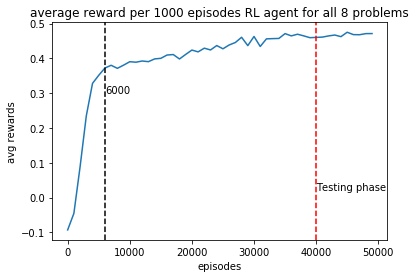

In [279]:

avg_reward_rl=np.mean(reward_df.values,1) #this will be used to produce the final comparison graph




plt.plot(list(range(0,max_episodes,1000)),avg_reward_rl)
plt.title("average reward per 1000 episodes RL agent for all 8 problems")
plt.xlabel("episodes")
plt.ylabel("avg rewards")
plt.text(40000,0.02,"Testing phase")
plt.axvline(testing_phase,color='r', linestyle='--')

converge_point = KneeLocator(range(0,max_episodes,1000), avg_reward_rl, direction='increasing') #knee locator
print("The point of convergence for the RL agent is ",converge_point.knee)
plt.axvline(converge_point.knee,color='k',linestyle='--')
plt.annotate('6000',xy=(converge_point.knee,0.3),xytext=(converge_point.knee,0.3))

## Visualizing each problem ID of RL agent

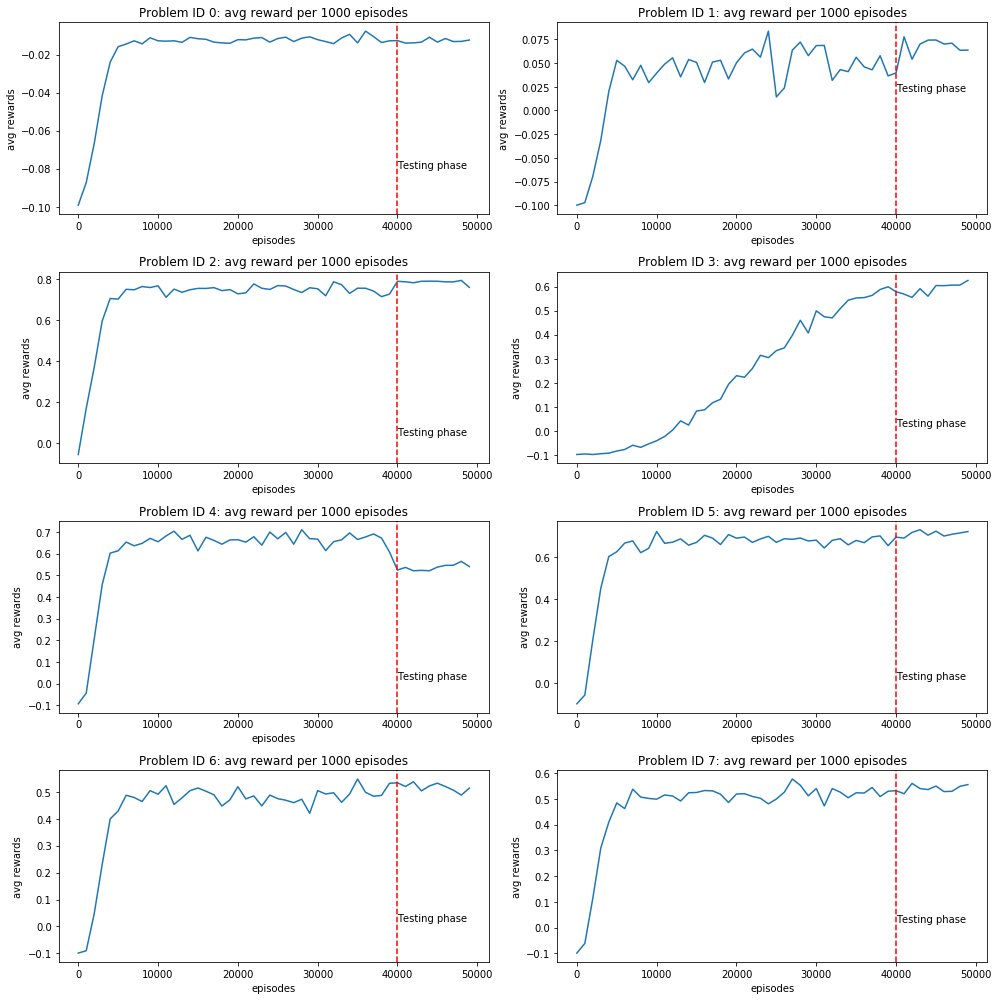

In [280]:


fig,ax=plt.subplots(nrows=4,ncols=2, figsize=(14,14))

testing_phase=int(max_episodes-0.2*max_episodes)

ax[0,0].plot(list(range(0,max_episodes,1000)),reward_df[0])
ax[0,0].set_xlabel("episodes")
ax[0,0].set_ylabel("avg rewards")
ax[0,0].axvline(testing_phase,color='r', linestyle='--')
ax[0,0].text(40000,-0.08,"Testing phase")
ax[0,0].set_title("Problem ID 0: avg reward per 1000 episodes")

ax[0,1].plot(list(range(0,max_episodes,1000)),reward_df[1])
ax[0,1].set_xlabel("episodes")
ax[0,1].set_ylabel("avg rewards")
ax[0,1].text(40000,0.02,"Testing phase")
ax[0,1].axvline(testing_phase,color='r', linestyle='--')

ax[0,1].set_title("Problem ID 1: avg reward per 1000 episodes")

ax[1,0].plot(list(range(0,max_episodes,1000)),reward_df[2])
ax[1,0].set_xlabel("episodes")
ax[1,0].set_ylabel("avg rewards")
ax[1,0].text(40000,0.04,"Testing phase")
ax[1,0].axvline(testing_phase,color='r', linestyle='--')

ax[1,0].set_title("Problem ID 2: avg reward per 1000 episodes")

ax[1,1].plot(list(range(0,max_episodes,1000)),reward_df[3])
ax[1,1].set_xlabel("episodes")
ax[1,1].set_ylabel("avg rewards")
ax[1,1].text(40000,0.02,"Testing phase")
ax[1,1].axvline(testing_phase,color='r', linestyle='--')

ax[1,1].set_title("Problem ID 3: avg reward per 1000 episodes")

ax[2,0].plot(list(range(0,max_episodes,1000)),reward_df[4])
ax[2,0].set_xlabel("episodes")
ax[2,0].set_ylabel("avg rewards")

ax[2,0].axvline(testing_phase,color='r', linestyle='--')
ax[2,0].text(40000,0.02,"Testing phase")
ax[2,0].set_title("Problem ID 4: avg reward per 1000 episodes")

ax[2,1].plot(list(range(0,max_episodes,1000)),reward_df[5])
ax[2,1].set_xlabel("episodes")
ax[2,1].set_ylabel("avg rewards")
ax[2,1].text(40000,0.02,"Testing phase")
ax[2,1].axvline(testing_phase,color='r', linestyle='--')

ax[2,1].set_title("Problem ID 5: avg reward per 1000 episodes")

ax[3,0].plot(list(range(0,max_episodes,1000)),reward_df[6])
ax[3,0].set_xlabel("episodes")
ax[3,0].set_ylabel("avg rewards")
ax[3,0].text(40000,0.02,"Testing phase")
ax[3,0].axvline(testing_phase,color='r', linestyle='--')

ax[3,0].set_title("Problem ID 6: avg reward per 1000 episodes")

ax[3,1].plot(list(range(0,max_episodes,1000)),reward_df[7])
ax[3,1].set_xlabel("episodes")
ax[3,1].set_ylabel("avg rewards")
ax[3,1].text(40000,0.02,"Testing phase")
ax[3,1].axvline(testing_phase,color='r', linestyle='--')

ax[3,1].set_title("Problem ID 7: avg reward per 1000 episodes")
plt.tight_layout()

# Random Agent:

In [281]:

def randomAgent(max_episode, max_iter_per_episode,problem_id,map_name_base,reward_hole,reward):   
    env = LochLomondEnv(problem_id=problem_id, is_stochastic=False, map_name_base=map_name_base, reward_hole=reward_hole,reward=reward)


    # Reset the random generator to a known state (for reproducibility)
    np.random.seed(0)

    flag=0
    
    goal_count=0 #to check how many goals acieved for all episodes combined
    hole_count=0 #to check how many holes the agent fell into for all episodes combined
    
    episode_count=1
    reward_per_episode=[]
    rewards_per_100_episodes=[]
    reward_sum=0

    #### Run a random/senseless agent
    for e in range(max_episodes): # iterate over episodes
        observation = env.reset() # reset the state of the env to the starting state     

        for iter in range(max_iter_per_episode):
                
            action = env.action_space.sample() # random sampling of actions
            observation, reward, done, info = env.step(action) #based on random action, it will change states

          # 

          #print("e,iter,reward,done =" + str(e) + " " + str(iter)+ " " + str(reward)+ " " + str(done))

          # Check if we are done and monitor rewards etc...
            reward_sum+=reward

            if (done and reward == 1):
                goal_count+=1    
                break
            elif (done and reward==reward_hole):
                hole_count+=1
                break
        if episode_count==1000:
            reward_per_episode.append(reward_sum/episode_count)
            reward_sum=0
            episode_count=0

        episode_count+=1
        
    accuracy=(goal_count/(goal_count+hole_count)) *100
    
    return accuracy, reward_per_episode



In [282]:
accuracy_random=[] #to be used for bar plots

## Problem ID: 0-7

In [283]:
map_name_base='8x8-base'
reward_hole=-0.1
reward=1
max_episode=50000
max_ter_per_episode=200
reward_np_array=np.empty((1,50))
accuracy_random=[]
for p_id in range(8):
    accuracy, reward_per_episode=randomAgent(max_episode=50000,max_iter_per_episode=200,problem_id=p_id,map_name_base=map_name_base,reward_hole=reward_hole,reward=reward)
    accuracy_random.append(accuracy)
    reward_np_array=np.vstack((reward_per_episode,reward_np_array))

reward_np_array=np.delete(reward_np_array,-1, axis=0) #deleting the last row as it was initialized to stack
print(reward_np_array.shape) #this is random agent average reward per 1000 episodes taken over 8 problems 

(8, 50)


## Visualizing the average of the rewards gained per 1000 episodes by the random agent accross all 8 problems:

In [284]:

#print(reward_np_array)
avg_reward_random=np.mean(reward_np_array,0) #taking mean of all the problem ids 

avg_reward_random.shape

(50,)

Text(0,0.5,'avg rewards')

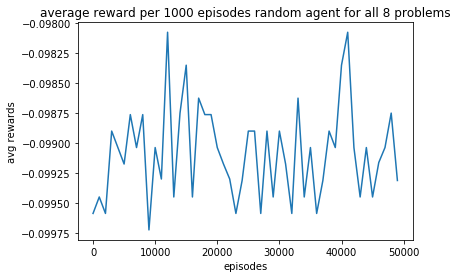

In [285]:
plt.plot(list(range(0,max_episodes,1000)),avg_reward_random)
plt.title("average reward per 1000 episodes random agent for all 8 problems")
plt.xlabel("episodes")
plt.ylabel("avg rewards")

# Simple Agent

In [286]:
def my_best_first_graph_search_for_vis(problem, f):
    """ This explains the standard A star operation. It examines which of the child nodes have the lowest f value and
    that child node becomes the next node. Whenever the agent steps on a node, it adds that node to the explored list. 
    This list will help to trace the path back from goal to start. Also, all the expanded nodes are added to a frontier list 
    and if the child node is already there, its f cost and parent is
    re-evaluated if found lesser than the previous path. Following this procedure, the agent reaches the goal. 
    """
    
    # we use these two variables at the time of visualisations
    iterations = 0
        
    f = memoize(f, 'f')
    node = Node(problem.initial)
    iterations += 1
    
    
    if problem.goal_test(node.state):  #if node is goal, it returns the node with the iterations it took
        iterations += 1
        return(iterations, node)
    
    frontier = PriorityQueue('min', f)  #a priority queue to store the node it is visiting and add the child nodes
                                        #in the order of ascending f, so a node will be dequeued first which has minimum f
    frontier.append(node)               #adding the current node to frontier
    iterations += 1
    explored = set()                    #initializing the explored list/set which will contain checked nodes which the agent
                                        #doesn't need to visit again.
    
    while frontier:                     #until frontier is not empty
        node = frontier.pop()           #immediately pop the current node which will got to the checked/ explored set
        iterations += 1
        if problem.goal_test(node.state): #checking if the node is the goal
            iterations += 1
            return(iterations, node)
        
        explored.add(node.state)         #the node is added to the explored set
        for child in node.expand(problem):              #expanding the checked node's children nodes
            if child.state not in explored and child not in frontier: #if child node hasn't been seen ever
                frontier.append(child)                #adding the child node to frontier priority queue for future checking
                iterations += 1                        
            elif child in frontier:                 #if child node was already in the frontier, checking if the cost to
                                                     #reach this node is better than the previous 
                incumbent = frontier[child]         #previous cost
                if f(child) < f(incumbent):        #if found better, delete the previous cost entry from frontier
                    del frontier[incumbent]
                    frontier.append(child)        #and add the new calculated cost as an entry in the priority queue with the new parent
                                                    #this will help to know shortest routes 
                    iterations += 1
        
        iterations += 1
        
    return None


def my_astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h') #h is heuristic distance to goal
    iterations, node = my_best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n)) #f=g+h
    return(iterations,  node)


def env2statespace(env):
    """ 
   This is creating the maze for us by taking the Lochlomond environment. It is returning the locations of every state, 
    the possible directions an agent can move from any state, initial state and final state. also, 
    the holes are directly ignored i.e. the agent doesn't take holes into consideration.
    

    Input:
        env: an Open AI Env follwing the std in the FrozenLake-v0 env

    Output:
        state_space_locations : a dict with the available states
        state_space_actions   : a dict of dict with available actions in each state
        state_start_id        : the start state
        state_goal_id         : the goal state  

        
    
    """
    state_space_locations = {} # create a dict
    for i in range(env.desc.shape[0]):
        for j in range(env.desc.shape[1]):   
            if not (b'H' in env.desc[i,j]):  #ignoring the holes
                state_id = "S_"+str(int(i))+"_"+str(int(j) ) #dictionay key for state locations
                state_space_locations[state_id] = (int(i),int(j))   #dictionary of key-coordinate
                if env.desc[i,j] == b'S':            # starting point
                    state_initial_id = state_id                                                 
                elif env.desc[i,j] == b'G':        # the goal
                    state_goal_id = state_id                      

                #-- Generate state / action list --#
                # First define the set of actions in the defined coordinate system             
                actions = {"west": [-1,0],"east": [+1,0],"north": [0,+1], "south": [0,-1]} #this will form our action space
                state_space_actions = {}
                for state_id in state_space_locations:      #for every location in state_space_location on the maze, we find out the possible actions                                 
                    possible_states = {}
                    for action in actions:
                        #-- Check if a specific action is possible --#
                        delta = actions.get(action)
                        state_loc = state_space_locations.get(state_id)
                        state_loc_post_action = [state_loc[0]+delta[0],state_loc[1]+delta[1]]

                        #-- Check if the new possible state is in the state_space, i.e., is accessible --#
                        state_id_post_action = "S_"+str(state_loc_post_action[0])+"_"+str(state_loc_post_action[1])                        
                        if state_space_locations.get(state_id_post_action) != None:
                            possible_states[state_id_post_action] = 1 
                        
                    #-- Add the possible actions for this state to the global dict --#                              
                    state_space_actions[state_id] = possible_states

    return state_space_locations, state_space_actions, state_initial_id, state_goal_id


state_space_locations, state_space_actions, state_initial_id, state_goal_id = env2statespace(env)



In [287]:
# Setup the parameters for the specific problem (you can change all of these if you want to) 
problem_id = 1        # problem_id \in [0:7] generates 8 diffrent problems on which you can train/fine-tune your agent 
reward_hole = 0.0     # Holes ignored
is_stochastic = False  # should be False for A-star (deterministic search) and True for the RL agent





def simpleAgent( problem_id,map_name_base):   
    env = LochLomondEnv(problem_id=problem_id, is_stochastic=False, map_name_base=map_name_base)

    



    # Create a dict representation of the state space
    state_space_locations, state_space_actions, state_initial_id, state_goal_id = env2statespace(env)

    # SOLUTION BEGIN
    '''
    UndirectedGraph() it creates the undirected maze, followed by maze_map.locations which has the locations of the problem. 
    
    '''
    
    
    maze_map = UndirectedGraph(state_space_actions) #creating the object maze of Lochlomond 
    maze_map.locations = state_space_locations #locations
    maze_problem = GraphProblem(state_initial_id, state_goal_id, maze_map) 
    #print(maze_problem) #the np 2D matrix representing the environment: Lochlomonod 
    # SOLUTION END


    iterations, node = my_astar_search_graph(problem=maze_problem, h=None)

    #-- Trace the solution --#
    solution_path = [node]       
    cnode = node.parent
    solution_path.append(cnode)
    while cnode.state != state_initial_id: #until current_node is not equal to starting point, keep tracing
        cnode = cnode.parent  
        solution_path.append(cnode)


    return iterations, solution_path

## Problem ID 0:


In [288]:
iterations_0, solution_path_0= simpleAgent( problem_id=0,map_name_base='8x8-base')

## Problem ID 1:

In [289]:
iterations_1, solution_path_1= simpleAgent( problem_id=1,map_name_base='8x8-base')

## Problem ID 2:

In [290]:
iterations_2, solution_path_2= simpleAgent( problem_id=2,map_name_base='8x8-base')

## Problem ID: 3

In [291]:
iterations_3, solution_path_3= simpleAgent( problem_id=3,map_name_base='8x8-base')

## Problem ID: 4

In [292]:
iterations_4, solution_path_4= simpleAgent( problem_id=4,map_name_base='8x8-base')

## Problem ID: 5

In [293]:
iterations_5, solution_path_5= simpleAgent( problem_id=5,map_name_base='8x8-base')

## Problem ID: 6

In [294]:
iterations_6, solution_path_6= simpleAgent( problem_id=6,map_name_base='8x8-base')

## Problem ID: 7

In [295]:
iterations_7, solution_path_7= simpleAgent( problem_id=7,map_name_base='8x8-base')

## Reward will always be 1 for Simple agent since it always reaches the goal after finding it.

# Average itearion required by simple agent to reach goal is 89

In [296]:
mean_iteration_simple=(iterations_0+iterations_1+iterations_2+iterations_3+iterations_4+iterations_5+iterations_6+iterations_7)/8

In [297]:
print("the mean minimum iterations required is : ",int(mean_iteration_simple))

the mean minimum iterations required is :  89


## Visualization:

### Overall comparison of 3 agents accross 8 problem IDs:

The point of convergence for the RL agent is  6000


Text(6000,0.3,'6000')

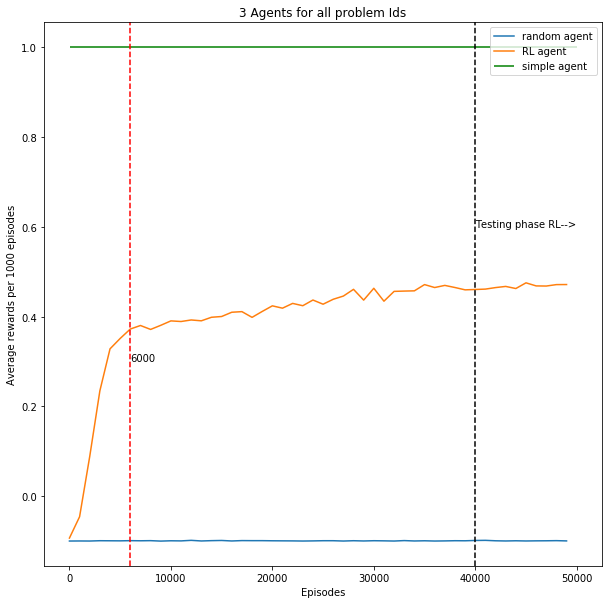

In [298]:
fig=plt.figure(figsize=(10,10))
plt.plot(list(range(0,max_episodes,1000)),avg_reward_random, label='random agent')
plt.plot(list(range(0,max_episodes,1000)),avg_reward_rl, label='RL agent')

plt.hlines(1, 89,max_episodes, 'green',label='simple agent') #the avg itearation needed by simple agent to reach goal is 89
plt.title("3 Agents for all problem Ids")
plt.ylabel("Average rewards per 1000 episodes")
plt.xlabel("Episodes")
plt.axvline(testing_phase,color='k', linestyle='--')
plt.text(40000,0.6,"Testing phase RL-->")
plt.legend(loc=0)



converge_point = KneeLocator(range(0,max_episodes,1000), avg_reward_rl, direction='increasing') #knee locator
print("The point of convergence for the RL agent is ",converge_point.knee)
plt.axvline(converge_point.knee,color='r',linestyle='--')
plt.annotate('6000',xy=(converge_point.knee,0.3),xytext=(converge_point.knee,0.3))

## Accuracy table:


In [299]:
accuracy_agents_df=pd.DataFrame()
accuracy_agents_df['random agent']=accuracy_random
accuracy_agents_df['RL agent']=accuracy_rl
accuracy_agents_df['simple agent']=[100 for i in range(0,8)]
accuracy_agents_df

,random agent,RL agent,simple agent
0,0.012001,0.227101,100
1,0.008000,17.468531,100
2,0.428000,83.355858,100
3,0.062000,63.128717,100
4,0.038000,61.734529,100
5,0.064000,78.180655,100
6,0.002000,58.822286,100
7,0.054000,60.327903,100
